In [92]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split

%matplotlib inline

top_path = 'C:/Users/Yannick/Google Drive/person_detection/pcds_dataset_detections/pcds_dataset_detected/'
label_file_name = 'pcds_dataset_labels_united.csv'
label_header = ['file_name', 'entering', 'exiting', 'video_type']
VAL_SIZE = 0.2
TEST_SIZE = 0.1
random_state = 42

plt.style.use('ggplot')
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})



In [110]:
def load_label_file():
    """Loads the label file as DataFrame
    """
    df_y = pd.read_csv(top_path + label_file_name, header=None, names=label_header)
    df_y['file_name'] = df_y['file_name'].apply(lambda row: row[:-4] + '.npy')
    return df_y

label_file = load_label_file()

def get_feature_file_names(): 
    '''
    Get names of all npy files for training

    Arguments: 
        top_path: Parent directory where to search for npy files
    '''
    names = list()
    for root, _, files in os.walk(top_path):
        for file_name in files: 
            if (file_name[-4:] == '.npy') and not ('label' in file_name): 
                names.append(os.path.join(root, file_name))
    return names

def get_label(file_name, df_y, inverse=False):
    """ Get the label for a given file
    Arguments: 
        file_name: Name of the file for training 
        df_y: Dataframe with labels for corresponding file names
        inverse: If the input array was flipped before so the opposite 
                 label shall be loaded 

    returns an int indicating the label 
    """
    if (('back_out' in file_name) and (inverse is False)) or\
       (('front_in' in file_name) and (inverse is True)):

        return get_exiting(file_name, df_y)

    elif (('front_in' in file_name) and (inverse is False)) or\
         (('back_out' in file_name) and (inverse is True)):

        return get_entering(file_name, df_y)

    else: 
        raise FileNotFoundError

def split_files():
    ''' Splits all files in the training set into train and test files
    and returns lists of names for train and test files
    # TODO: Split files according to the categories equally distributed (stratified)
    '''
    labels = list()
    df_names = pd.Series(get_feature_file_names())
    
    for name in df_names: 
        labels.append(int(get_label(name, label_file, inverse=False).values))

    def get_path_tail(row):
        if 'front_in' in row:
            search_str = row[row.find('front_in'):]
        else: 
            search_str = row[row.find('back_out'):]

        return search_str

    #replace .avi with .npy
    df_names = df_names.apply(lambda row: row[:-4] + '.npy')
    df_names = df_names.apply(get_path_tail)
    train, test = train_test_split(df_names,
                                   train_size= 1 - TEST_SIZE - VAL_SIZE,
                                   random_state=42,
                                   stratify=labels)                          

    validation, test = train_test_split(test,
                                        test_size=TEST_SIZE / (VAL_SIZE + TEST_SIZE), 
                                        random_state=random_state)
    
    
    return train, validation, test

def get_entering(file_name, df_y): 
    ''' Get number of entering persons to existing training sample. 

    Arguments: 
        file_name: Name of given training sample
        df_y: Dataframe with all labels for all samples

        returns: Label for given features
    '''
    search_str = file_name.replace('\\', '/').replace('\\', '/')
    
    if 'front_in' in file_name:
        search_str = search_str[search_str.find('front_in'):]
    else: 
        search_str = search_str[search_str.find('back_out'):]

    entering = df_y.loc[df_y.file_name == search_str].entering
    return entering

def get_exiting(file_name, df_y): 
    '''Get number of exiting persons to existing training sample. 

    Arguments: 
        file_name: Name of given training sample
        df_y: Dataframe with all labels for all samples

        returns: DF with exiting persons for given file
    '''
    search_str = file_name.replace('\\', '/').replace('\\', '/')
    
    if 'front_in' in file_name:
        search_str = search_str[search_str.find('front_in'):]
    else: 
        search_str = search_str[search_str.find('back_out'):]

    entering = df_y.loc[df_y.file_name == search_str].exiting
    return entering 

In [111]:
train, val, test = split_files()

In [112]:
test.head()


2278    front_in\normal\uncrowd\2015_05_10_16_38_39Fro...
1557    back_out\normal\uncrowd\2016_04_08_08_29_50Bac...
2614    front_in\normal\uncrowd\2016_04_09_16_05_05Fro...
1563    back_out\normal\uncrowd\2016_04_08_09_12_54Bac...
1829    front_in\noisy\uncrowd\2015_05_08_12_14_09Fron...
dtype: object

In [113]:
train.to_csv('train_split.csv', index=False, sep=',')
test.to_csv('test_split.csv', index=False, sep=',')
val.to_csv('validation_split.csv', index=False, sep=',')

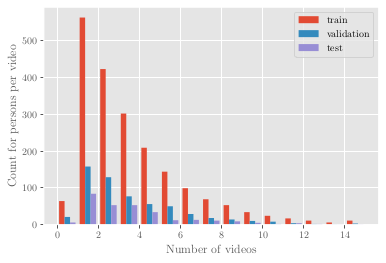

In [116]:
labels_train, labels_val, labels_test = list(), list(), list()
for name in train: 
    labels_train.append(int(get_label(name, label_file, inverse=False).values))
for name in val:
    labels_val.append(int(get_label(name, label_file, inverse=False).values))
for name in test:
    labels_test.append(int(get_label(name, label_file, inverse=False).values))

plt.hist([labels_train, labels_val, labels_test], label=['train', 'validation', 'test'],
         bins=max([max(labels_train), max(labels_val), max(labels_test)]))

plt.xlabel('Number of videos')
plt.ylabel('Count for persons per video')
plt.legend(loc='upper right')

plt.show()
plt.savefig('C:/Users/Yannick/OneDrive/Dokumente/Studium/Masterarbeit/Ausarbeitung/98_images/train_test_split.pgf')


In [125]:
supercharge_bins = [4, 7, 9, 10, 11, 12, 13]

supercharged_crowdeds = train.copy()
for name in train: 
    label = int(get_label(name, label_file, inverse=False).values)
    for bin_num in supercharge_bins:
        if label >= bin_num:
            supercharged_crowdeds = supercharged_crowdeds.append(pd.Series(name))


In [127]:
supercharged_crowdeds.to_csv('supercharged_crowdeds_train_split.csv', index=False, sep=',')


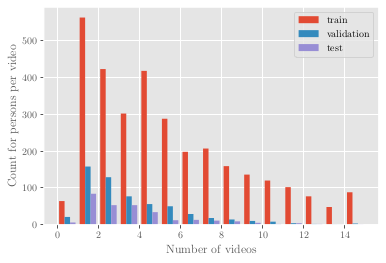

In [126]:
labels_train_supercharged, labels_val, labels_test = list(), list(), list()
for name in supercharged_crowdeds: 
    labels_train_supercharged.append(int(get_label(name, label_file, inverse=False).values))
for name in val:
    labels_val.append(int(get_label(name, label_file, inverse=False).values))
for name in test:
    labels_test.append(int(get_label(name, label_file, inverse=False).values))

plt.hist([labels_train_supercharged, labels_val, labels_test], label=['train', 'validation', 'test'],
         bins=max([max(labels_train_supercharged), max(labels_val), max(labels_test)]))

plt.xlabel('Number of videos')
plt.ylabel('Count for persons per video')
plt.legend(loc='upper right')

plt.show()
plt.savefig('C:/Users/Yannick/OneDrive/Dokumente/Studium/Masterarbeit/Ausarbeitung/98_images/supercharged_crowdeds_train_test_split.pgf')